
## Notes


 - ~~un notebook par réunion~~.
 - ~~mse en echelle log10~~.

 - operateur d’advection cf torch qg et faire une prediction (later)
 - ~~scatter plot U vs Ugeo (un peu evolué)~~
 - un test avec vitesse shuffled pour verifier qu’on est capable d’avoir qqcho qui ne marche pas.
 - ~~Test impact de niveau de bruit sur prediction.~~
 - ~~métrique d’evaluation a posteriori (sans entrainement) basé sur prediction à N-jours~~
 - (selon résultat) réfléchir à entrainement avec critere prédiction sur plusieurs pas de temps.
 - ~~constructer ugeo lissé type AVISO (SSH—> lissée —> ugeo)  [lissage a optimiser selon critère spectral]~~ 
 - ~~comparer ugeo lissé avec u total~~
 - si le temps et si on a une target dégradée: entrainement avec ugeo lissé
 





In [161]:
import numpy as np                                                                                                                                                                                  
import xarray as xr                                                                                                                                                                                 
import os                                                                                                                                                                                           
import matplotlib.pyplot as plt                                                                                                                                                                     
import matplotlib.cm as cm    
import matplotlib.pyplot as plt
import numpy as np                                                                                                                                                                                  
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.reset_defaults()
sns.set_context("talk", font_scale=0.8)

%load_ext autoreload
%autoreload 2
                                                                                                                                                                                                    
def rmse(y1, y2):                                                                                                                                                                                   
    return np.sqrt(((y1-y2)**2)).mean()    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scatter plot U vs Ugeo


In [193]:
from pathlib import Path
import sys


upathlist = Path('/home/anas/MEOM_Workspace/data/raw/Geo_curr/').glob('*gridU-2D.nc')
upathlist =sorted(upathlist)
vpathlist = Path('/home/anas/MEOM_Workspace/data/raw/Geo_curr/').glob('*gridV-2D.nc')
vpathlist =sorted(vpathlist)

u_m=np.zeros((1092))
ug_m=np.zeros((1092))
v_m=np.zeros((1092))
vg_m=np.zeros((1092))
vel=np.zeros((1092))
gvel=np.zeros((1092))
v_err=np.zeros((1092))
u_err=np.zeros((1092))

j=0


for upath,vpath in zip(upathlist, vpathlist):
    #print(path,vpath)
    u  = xr.open_dataset(upath).sozocrtx.data
    ug = xr.open_dataset(upath).vozocrtx.data
    v  = xr.open_dataset(vpath).somecrty.data
    vg = xr.open_dataset(vpath).vomecrty.data
    u[np.isnan(u)] = 0
    ug[np.isnan(ug)] = 0
    v[np.isnan(v)] = 0
    vg[np.isnan(vg)] = 0
 
    for i in range(4):
        v_m[j]  = v[i,np.nonzero(v[i,:,:])].mean() 
        vg_m[j] = vg[i,np.nonzero(vg[i,:,:])].mean() 
        u_m[j]  = u[i,np.nonzero(u[i,:,:])].mean() 
        ug_m[j] = ug[i,np.nonzero(ug[i,:,:])].mean()
        tvel=np.sqrt(np.square(v[i,:,:])+np.square(u[i,:,:]))
        tgvel=np.sqrt(np.square(vg[i,:,:])+np.square(ug[i,:,:]))
        vel[j]=tvel[tvel.nonzero()].mean()
        gvel[j]=tgvel[tgvel.nonzero()].mean()
        v_err[j]=rmse(v[i,:,:],vg[i,:,:]) 
        u_err[j]=rmse(u[i,:,:],ug[i,:,:]) 
        
        j=j+1
        print(j,end = "\r")
        #sys.stdout.flush()


mydata={'ug':ug_m, 'vg':vg_m, 'current_Amp': vel, 'u':u_m, 'v':v_m, 'g_current_Amp': gvel, 'v_err': v_err, 'u_err':u_err}
df= pd.DataFrame(mydata)
df.to_pickle("data.pkl")
print('done')


done


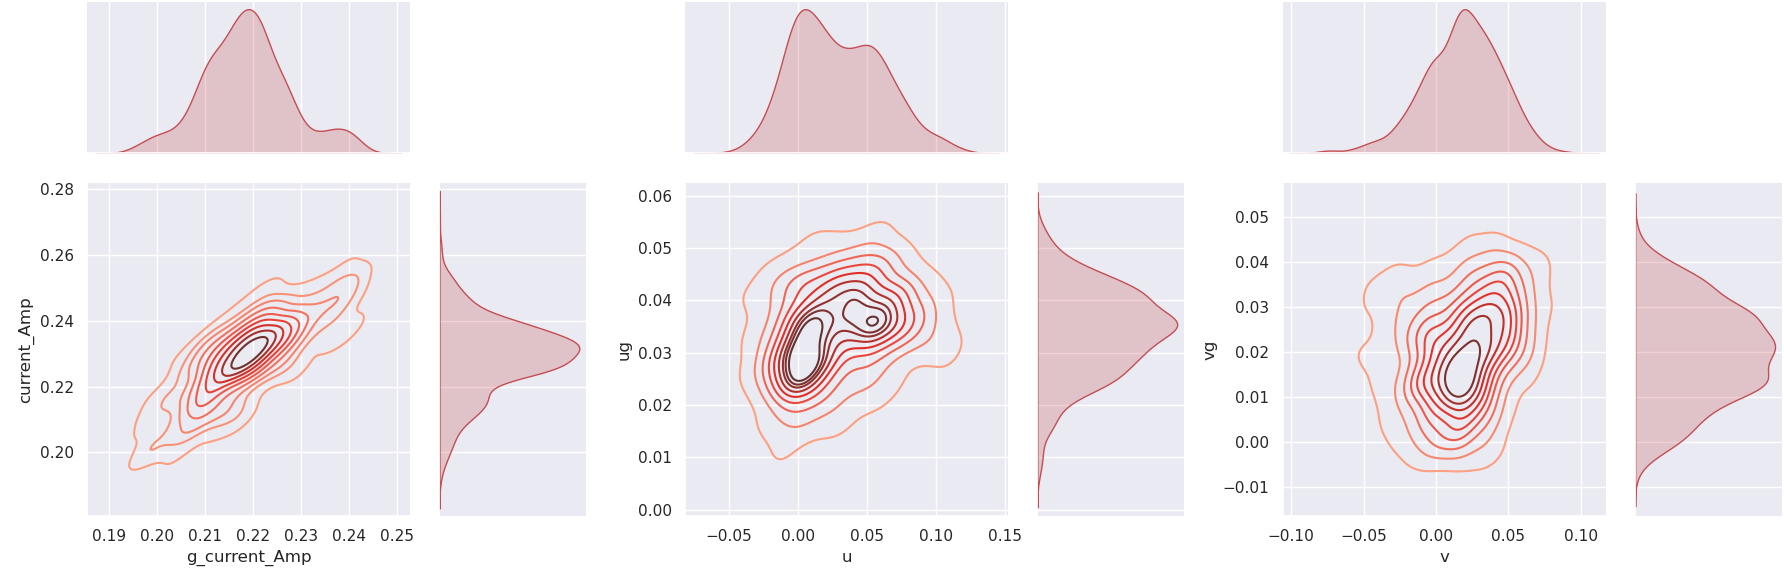

In [13]:
import seaborn as sns
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from myfuncts import SeabornFig2Grid



df = pd.read_pickle("data.pkl")

g = sns.JointGrid(x="g_current_Amp", y="current_Amp", data=df, height=5, ratio=2)
g.plot_marginals(sns.kdeplot, color="r", shade=True,  thresh=0)
g.plot_joint(sns.kdeplot, cmap="Reds_d")
#g.fig.suptitle('$\sqrt{u^2+v^2}$')

g2 = sns.JointGrid(x="u", y="ug", data=df, height=5, ratio=2)
g2.plot_marginals(sns.kdeplot, color="r", shade=True,  thresh=0)
g2.plot_joint(sns.kdeplot, cmap="Reds_d")

g3 = sns.JointGrid(x="v", y="vg", data=df, height=5, ratio=2)
g3.plot_marginals(sns.kdeplot, color="r", shade=True,  thresh=0)
g3.plot_joint(sns.kdeplot, cmap="Reds_d")



fig = plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1, 3)


mg0 = SeabornFig2Grid(g, fig, gs[0])
mg1 = SeabornFig2Grid(g2, fig, gs[1])
mg2 = SeabornFig2Grid(g3, fig, gs[2])

gs.tight_layout(fig)
plt.show()

# Scatter plot U vs  ugeo (Smooth SSH)


<class 'xarray.core.dataset.Dataset'>
done
hh


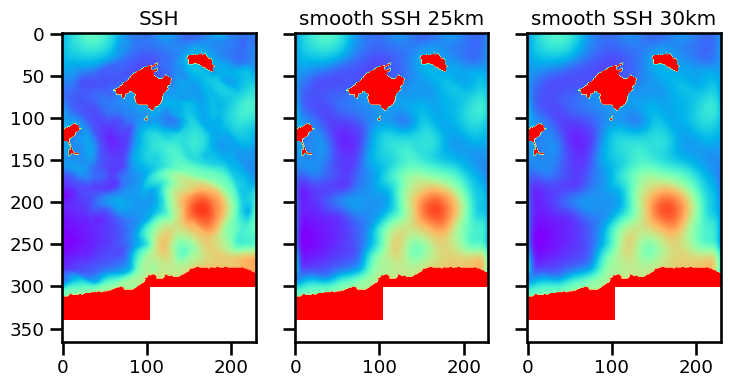

In [197]:
from myfuncts import create_filter
import gcm_filters
import numpy as np
import xarray as xr

filter25km, filter30km, ds=create_filter()

import matplotlib.cm as cm
import matplotlib.pyplot as plt
ssh25= filter25km.apply(ds.sossheig, dims=['y', 'x'])
ssh30= filter30km.apply(ds.sossheig, dims=['y', 'x'])
print('hh')
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

ax1.imshow(np.flipud(ds.sossheig[1,:,:]),cmap=cm.rainbow)
ax1.title.set_text('SSH')

ax2.imshow(np.flipud(ssh25[1,:,:]),cmap=cm.rainbow)
ax2.title.set_text('smooth SSH 25km')

ax3.imshow(np.flipud(ssh30[1,:,:]),cmap=cm.rainbow)
ax3.title.set_text('smooth SSH 30km')

plt.show()


In [9]:
from pathlib import Path
import sys


upathlist = Path('/home/anas/MEOM_Workspace/data/raw/Daily2018/').glob('*gridU-2D.nc')
upathlist =sorted(upathlist)
vpathlist = Path('/home/anas/MEOM_Workspace/data/raw/Daily2018/').glob('*gridV-2D.nc')
vpathlist =sorted(vpathlist)

u_m=np.zeros((1092))
ug_m=np.zeros((1092))
v_m=np.zeros((1092))
vg_m=np.zeros((1092))
vel=np.zeros((1092))
gvel=np.zeros((1092))
v_err=np.zeros((1092))
u_err=np.zeros((1092))


j=0

for upath,vpath in zip(upathlist, vpathlist):
    #print(path,vpath)
    u  = xr.open_dataset(upath).sozocrtx.data
    ug = xr.open_dataset(upath).ugeo.data
    v  = xr.open_dataset(vpath).somecrty.data
    vg = xr.open_dataset(vpath).vgeo.data
    u[np.isnan(u)] = 0
    ug[np.isnan(ug)] = 0
    v[np.isnan(v)] = 0
    vg[np.isnan(vg)] = 0
 
    for i in range(4):
        v_m[j]  = v[i,np.nonzero(v[i,:,:])].mean() 
        vg_m[j] = vg[i,np.nonzero(vg[i,:,:])].mean() 
        u_m[j]  = u[i,np.nonzero(u[i,:,:])].mean() 
        ug_m[j] = ug[i,np.nonzero(ug[i,:,:])].mean()
        tvel=np.sqrt(np.square(v[i,:,:])+np.square(u[i,:,:]))
        tgvel=np.sqrt(np.square(vg[i,:,:])+np.square(ug[i,:,:]))
        vel[j]=tvel[tvel.nonzero()].mean()
        gvel[j]=tgvel[tgvel.nonzero()].mean()
        v_err[j]=rmse(v[i,:,:],vg[i,:,:]) 
        u_err[j]=rmse(u[i,:,:],ug[i,:,:]) 

        j=j+1
        print(j,end = "\r")
        #sys.stdout.flush()


mydata={'ug':ug_m, 'vg':vg_m, 'current_Amp': vel, 'u':u_m, 'v':v_m, 'g_current_Amp': gvel, 'v_err': v_err, 'u_err':u_err}
df= pd.DataFrame(mydata)
df.to_pickle("data_geo.pkl")
print('done')


done


### The geostrophic currents are computed based on ssh(25km)

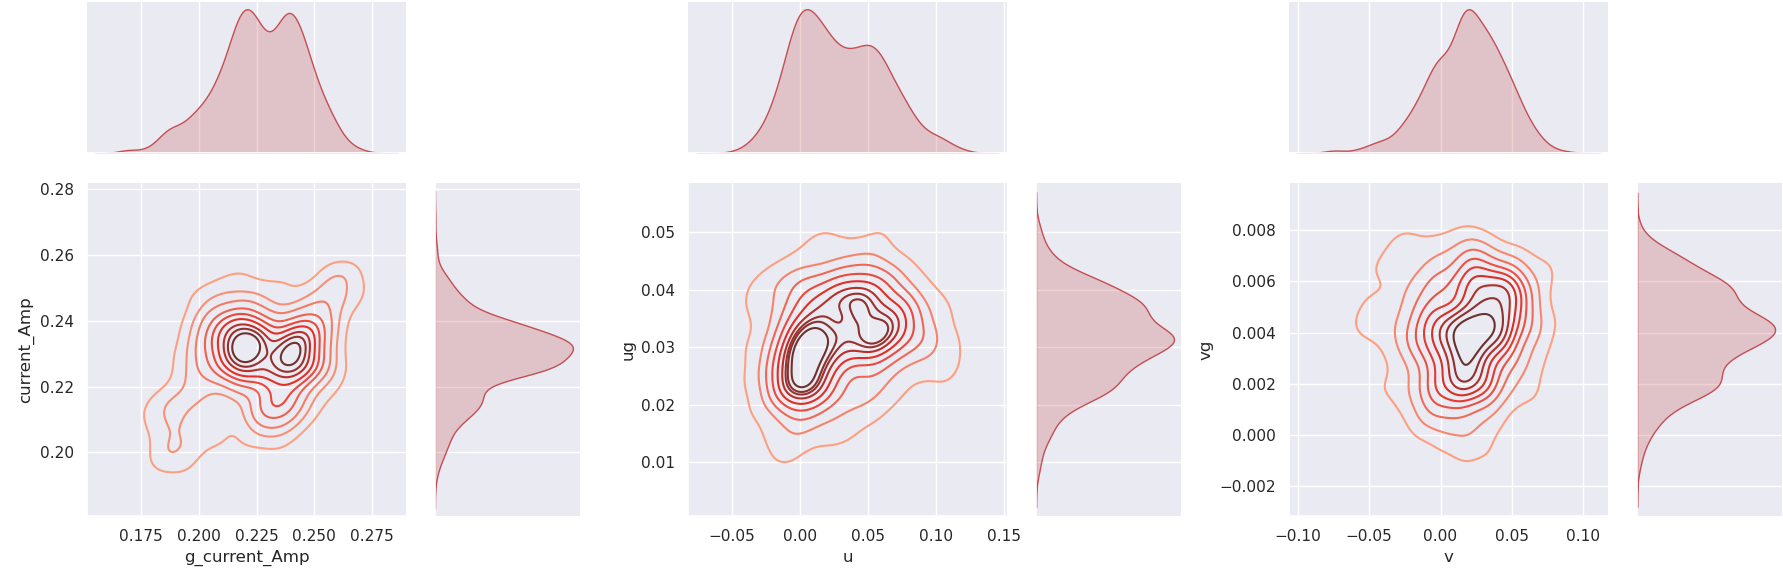

In [3]:
import seaborn as sns
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from myfuncts import SeabornFig2Grid



df = pd.read_pickle("data_geo.pkl")

g = sns.JointGrid(x="g_current_Amp", y="current_Amp", data=df, height=5, ratio=2)
g.plot_marginals(sns.kdeplot, color="r", shade=True,  thresh=0)
g.plot_joint(sns.kdeplot, cmap="Reds_d")
#g.fig.suptitle('$\sqrt{u^2+v^2}$')

g2 = sns.JointGrid(x="u", y="ug", data=df, height=5, ratio=2)
g2.plot_marginals(sns.kdeplot, color="r", shade=True,  thresh=0)
g2.plot_joint(sns.kdeplot, cmap="Reds_d")

g3 = sns.JointGrid(x="v", y="vg", data=df, height=5, ratio=2)
g3.plot_marginals(sns.kdeplot, color="r", shade=True,  thresh=0)
g3.plot_joint(sns.kdeplot, cmap="Reds_d")



fig = plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1, 3)


mg0 = SeabornFig2Grid(g, fig, gs[0])
mg1 = SeabornFig2Grid(g2, fig, gs[1])
mg2 = SeabornFig2Grid(g3, fig, gs[2])

gs.tight_layout(fig)
plt.show()

# Evaluate advection for N days

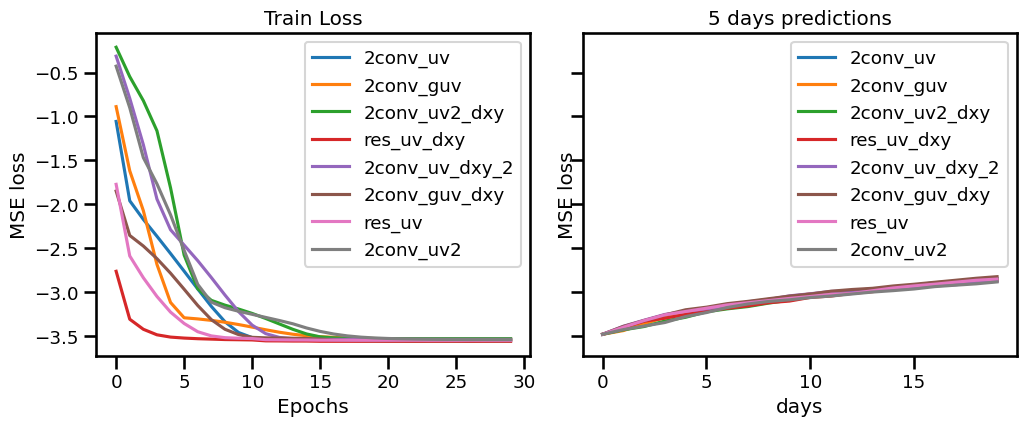

In [3]:
import myfuncts 

sims=myfuncts.load_sims()


plt.rcParams["figure.figsize"] = [10.50, 4.50]
norm = 0.43405532837#sims[0].tloss.values[0]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for sim in sims:
        ax1.plot(np.log10(sim.tloss/norm),label=sim.name)
        ax2.plot(np.log10(sim.dloss/norm),label=sim.name)

ax1.title.set_text('Train Loss')
ax1.set_ylabel('MSE loss')
ax1.set_xlabel('Epochs')
ax1.legend()

ax2.title.set_text('5 days predictions')
ax2.set_ylabel('MSE loss')
ax2.set_xlabel('days')
ax2.legend()            
plt.tight_layout()
plt.show()


(1, 42, 366, 230)


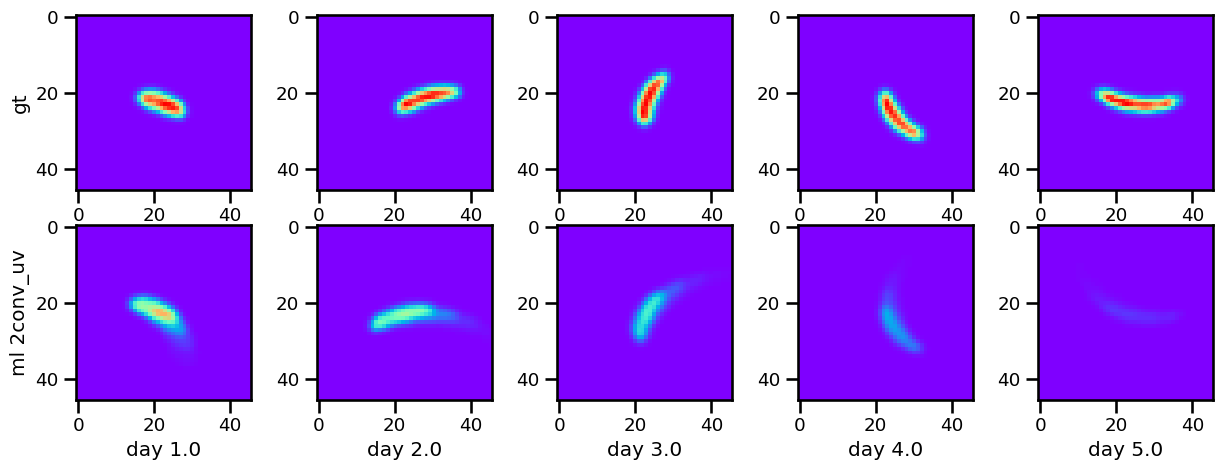

In [254]:
import myfuncts 


ds=myfuncts.load_5d()


ds
mmax=1

k=23
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(15,5))
axs = axs.ravel()
j=0
# def demo_plot_and_yield():
indices=[4,8,12,16,20,25,29,33,37, 41]
for iax, i in zip(axs, indices):
    j=i
    ind = np.unravel_index(np.argmax(ds[-1,j,:,:], axis=None), ds[-1,j,:,:].shape)
    iax.imshow(ds[-1,j,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                   cmap=cm.rainbow, vmin=0, vmax=mmax)
    if i==4 :
        iax.set_ylabel('gt')
    if i==25:
        iax.set_ylabel('ml 2conv_uv')
    if i>24:
        iax.set_xlabel('day ' + str(((i-20)-1)/4))
        
    
print(ds.shape)
plt.show()

# Train with u(t)=$u(t) + \alpha \times u(rand(t))$

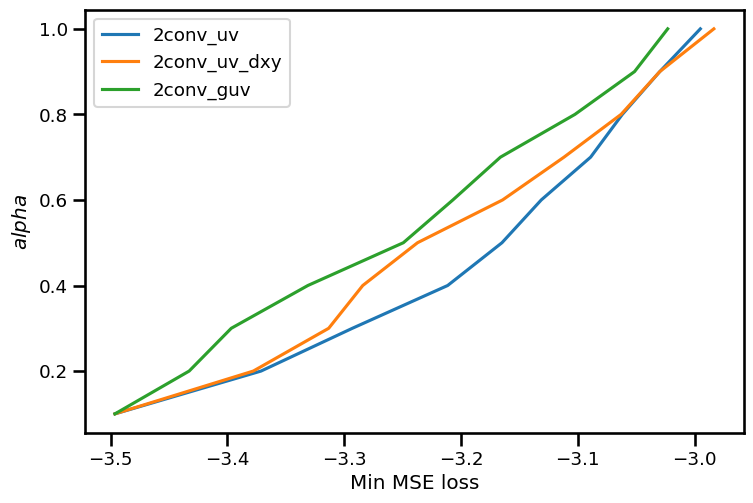

In [4]:
import myfuncts 

sims=myfuncts.load_sims2()

plt.rcParams["figure.figsize"] = [8.50, 5.50]

a=np.arange(start=0.1, stop=1.1, step=0.1)

for sim in sims:
    plt.plot(np.log10(sim.aloss.squeeze()/norm),a, label=sim.name)
    #print(sim.aloss)

plt.ylabel('$alpha$')
plt.xlabel('Min MSE loss')
plt.legend()

plt.show()
